### Sentiment analysis of the six subjects (partion of the 20 newsgroups)

Processing data... Estimated time: 1-2 minutes.

Done: Close the plot window to continue...


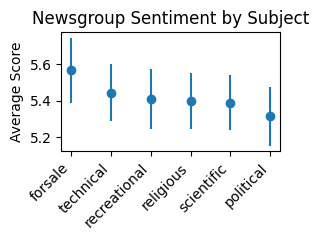


Newsgroup Sentiment Statistics:
forsale: 5.565 (±0.179), size: 963
technical: 5.443 (±0.155), size: 4861
recreational: 5.407 (±0.164), size: 3969
religious: 5.397 (±0.153), size: 2422
scientific: 5.389 (±0.151), size: 3940
political: 5.313 (±0.162), size: 2621

Overall Statistics:
mean: 5.406
median: 5.401
std: 0.167
25th percentile: 5.312
75th percentile: 5.495


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.tokenize import word_tokenize  #type:ignore
from collections import defaultdict

#define categories
subjects = {
    'scientific': ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
    'political': ['talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc'],
    'technical': ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                 'comp.sys.mac.hardware', 'comp.windows.x'],
    'forsale': ['misc.forsale'],
    'religious': ['soc.religion.christian', 'talk.religion.misc', 'alt.atheism'],
    'recreational': ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'],
}

#create a mapping from original subject to new merged subject
subject_mapping = {}
for new_subject, old_subjects in subjects.items():
    for subject in old_subjects:
        subject_mapping[subject] = new_subject

#the wordlist can be found at https://doi.org/10.1371/journal.pone.0026752.s001
print("Processing data... Estimated time: 1-2 minutes.")
CSV_NAME = "data.csv"
WORDLIST_NAME = os.path.join("Jonatan", "LabMT_wordlist.txt")
newsgroup_df = pd.read_csv(CSV_NAME)
wordlist_df = pd.read_csv(WORDLIST_NAME, sep='\t', na_values='--')

#map original labels to new categories
newsgroup_df['label'] = newsgroup_df['label'].map(subject_mapping)
sentiment_dict = dict(zip(wordlist_df['word'], wordlist_df['happiness_average']))

def calculate_sentiment(text, sentiment_dct):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())
        scores = [sentiment_dct[word] for word in tokens if word in sentiment_dct]
        return np.mean(scores) if scores else None
    return None

newsgroup_df['sentiment'] = newsgroup_df['text'].apply(
    lambda x: calculate_sentiment(x, sentiment_dict)
)

#group by label and calculate statistics
group_stats = defaultdict(dict) #type:ignore
for label in newsgroup_df['label'].unique():
    group_sentiments = newsgroup_df[newsgroup_df['label'] == label]['sentiment']
    group_stats[label] = {
        'mean': np.mean(group_sentiments),
        'std': np.std(group_sentiments),
        'size': len(group_sentiments)
    }
#sort groups by mean sentiment
sorted_grps = sorted(group_stats.items(),
                      key=lambda x: x[1]['mean'],
                      reverse=True)
plt.figure(figsize=(3, 2.5))
grps = [g[0] for g in sorted_grps]
sentiments = [g[1]['mean'] for g in sorted_grps]
errors = [g[1]['std'] for g in sorted_grps]

plt.errorbar(range(len(grps)), sentiments, yerr=errors, fmt='o')
plt.xticks(range(len(grps)), grps, rotation=45, ha='right')
plt.ylabel('Average Score')
plt.title('Newsgroup Sentiment by Subject')
plt.tight_layout()
print("\nDone: Close the plot window to continue...")
plt.show()

print("\nNewsgroup Sentiment Statistics:")
for group, stats in sorted_grps:
    print(f"{group}: {stats['mean']:.3f} (±{stats['std']:.3f}), size: {stats['size']}")
all_sents = newsgroup_df['sentiment'].dropna()
print("\nOverall Statistics:")
print(f"mean: {np.mean(all_sents):.3f}")
print(f"median: {np.median(all_sents):.3f}")
print(f"std: {np.std(all_sents):.3f}")
print(f"25th percentile: {np.percentile(all_sents, 25):.3f}")
print(f"75th percentile: {np.percentile(all_sents, 75):.3f}")

### LDA Algorithm (Model Training)

In [ ]:
# Latent Dirichlet Allocation (LDA) training
import pandas as pd
from datetime import datetime
from gensim.corpora import Dictionary  #type:ignore
from gensim.models import LdaModel  #type:ignore
from nltk.tokenize import word_tokenize  #type:ignore
from nltk.corpus import stopwords  #type:ignore
from nltk.stem import WordNetLemmatizer  #type:ignore
import nltk  #type:ignore
import os
import pickle
import string
import time

nltk.download('punkt_tab')

OUTPUT_DIR = 'models_lda'
LDA_NUM_TOPICS = 6
LDA_NUM_PASSES = 100
FILTER_BELOW = 2  #ignore rare words that exist in fewer than 2 documents
FILTER_ABOVE = 0.7  #ignore common words that occour in more than 90% of the documents

def run_lda_analysis(csv_path, num_topics=LDA_NUM_TOPICS, num_passes=LDA_NUM_PASSES):
    """
    Run LDA topic modeling on text data from a CSV file.
    num_topics (int): topics for LDA model (default: 5)
    num_passes (int): passes for LDA training (default: 30)
    """
    print("Starting the LDA process...")
    start_time = time.time()

    # Automatically download required NLTK data
    print("\nChecking and downloading required NLTK data...")
    required_nltk_data = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger']
    for item in required_nltk_data:
        try:
            nltk.data.find(f'tokenizers/{item}' if item == 'punkt'
                          else f'corpora/{item}' if item in ['stopwords', 'wordnet']
                          else f'taggers/{item}')
        except LookupError:
            print(f"Downloading {item}...")
            nltk.download(item)

    #part1
    print("\n1. Loading CSV file...")
    df = pd.read_csv(csv_path)
    print(f"   Loaded {len(df)} documents")

    #part2
    print("\n2. Initializing NLTK components...")
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    print("   Initialized lemmatizer and stopwords")

    def preprocess(text):
        text = str(text).lower()  #convert to string
        text = text.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  #remove stopwords and lemmatize
        return tokens

    #part3
    print("\n3. Preprocessing texts...")
    texts = []
    for i, doc in enumerate(df['text']):
        if i % 1000 == 0:  #print progress every 1000doc
            print(f"   Processing document {i}/{len(df)}")
        texts.append(preprocess(doc))
    print("   Preprocessing complete")

    #part4
    print("\n4. Creating dictionary...")
    dictionary = Dictionary(texts)
    print(f"   Initial dictionary size: {len(dictionary)}")

    #part5
    print("\n5. Filtering dictionary...")
    dictionary.filter_extremes(no_below=FILTER_BELOW, no_above=FILTER_ABOVE)  #filter out extreme frequencies
    print(f"   Dictionary size after filtering: {len(dictionary)}")

    #part6
    print("\n6. Creating corpus...")
    corpus = [dictionary.doc2bow(text) for text in texts]
    print(f"   Corpus size: {len(corpus)}")

    #part7
    print("\n7. Training LDA model...")
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=num_passes)
    print("   LDA model training complete")

    #part8
    print("\n8. Final Topics:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"\nTopic {idx}:")
        print(topic)

    end_time = time.time()
    print(f"\nTotal processing time: {(end_time - start_time):.2f} seconds")
    print("\nAdditional Statistics:")  #print more statistics yay
    print(f"Number of documents processed: {len(df)}")
    print(f"Final vocabulary size: {len(dictionary)}")
    print(f"Average tokens per document: {sum(len(text) for text in texts)/len(texts):.1f}")
    return lda_model, dictionary, corpus, texts

def save_model_results(lda_model, dictionary, corpus, texts, output_dir=OUTPUT_DIR):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  #generate timestamp for unique filenames each time code is run
    model_path = os.path.join(output_dir, f'lda_model_{timestamp}')
    lda_model.save(model_path)  #save model
    dict_path = os.path.join(output_dir, f'dictionary_{timestamp}.dict')
    dictionary.save(dict_path)  #save dictionary

    corpus_path = os.path.join(output_dir, f'corpus_{timestamp}.pkl')  #save corpus and texts using pickle
    texts_path = os.path.join(output_dir, f'texts_{timestamp}.pkl')  #save corpus and texts using pickle
    with open(corpus_path, 'wb') as f:
        pickle.dump(corpus, f)
    with open(texts_path, 'wb') as f:
        pickle.dump(texts, f)
    print(f"\nAll data saved in {output_dir}")
    return timestamp

if __name__ == "__main__":
    # Configuration
    CSV_PATH = 'processed_data.csv'
    try:
        _lda_model, _dictionary, _corpus, _texts = run_lda_analysis(
            csv_path=CSV_PATH,
            num_topics=LDA_NUM_TOPICS,
            num_passes=LDA_NUM_PASSES
        )
        save_model_results(_lda_model, _dictionary, _corpus, _texts)
    except Exception as e:
        print(f"An error occurred: {str(e)}")

### LDA Algorithm (Analysis and results)


=== LDA Analysis Results ===

Topics and their top words:

Topic 0:
  would: 0.0110, one: 0.0100, get: 0.0100, like: 0.0090, dont: 0.0080, time: 0.0070, good: 0.0060, know: 0.0060, im: 0.0050, could: 0.0050

Topic 1:
  system: 0.0060, key: 0.0050, information: 0.0050, space: 0.0050, u: 0.0040, new: 0.0040, use: 0.0040, program: 0.0040, state: 0.0030, public: 0.0030

Topic 2:
  1: 0.0330, 0: 0.0240, 2: 0.0240, 3: 0.0150, game: 0.0130, 4: 0.0120, 5: 0.0090, team: 0.0080, 6: 0.0070, 7: 0.0070

Topic 3:
  x: 0.0170, file: 0.0090, window: 0.0070, use: 0.0060, system: 0.0060, program: 0.0050, drive: 0.0050, email: 0.0050, thanks: 0.0050, image: 0.0040

Topic 4:
  people: 0.0090, one: 0.0080, would: 0.0080, god: 0.0070, say: 0.0050, think: 0.0050, dont: 0.0050, know: 0.0050, u: 0.0040, right: 0.0040

Topic 5:
  armenian: 0.0150, maxaxaxaxaxaxaxaxaxaxaxaxaxaxax: 0.0120, turkish: 0.0070, israel: 0.0060, israeli: 0.0050, arab: 0.0050, jew: 0.0050, turk: 0.0040, said: 0.0040, war: 0.0040


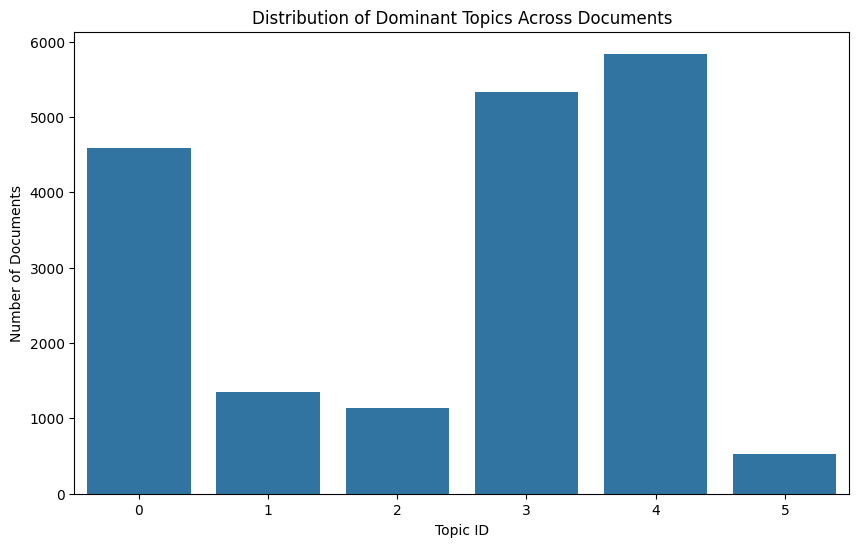

In [ ]:
# Latent Dirichlet Allocation (LDA) analysis and results
import matplotlib.pyplot as plt
import seaborn as sns  #type:ignore
import numpy as np
import os
import pickle
import pandas as pd
from gensim.models import LdaModel  #type:ignore
from gensim.corpora import Dictionary  #type:ignore
from datetime import datetime

OUTPUT_DIR = 'models_lda'

def analyze_lda_results(lda_model, corpus):
    print("\n=== LDA Analysis Results ===")

    #top words
    print("\nTopics and their top words:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"\nTopic {idx}:")
        #convert the topic string to a more readable format
        words = [(word.split('*')[1].strip().replace('"', ''), float(word.split('*')[0]))
                for word in topic.split(' + ')]
        words_line = ", ".join([f"{word}: {prob:.4f}" for word, prob in words])
        print(f"  {words_line}")

def visualize_lda_results(lda_model, corpus):
    #not in use for now
    #topic distribution across documents
    doc_topics = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]
    plt.figure(figsize=(10, 6))
    sns.countplot(x=doc_topics)
    plt.title('Distribution of Dominant Topics Across Documents')
    plt.xlabel('Topic ID')
    plt.ylabel('Number of posts belonging to topic')
    plt.show()

def load_and_analyze_results(model_path, dict_path, corpus_path, texts_path):
    #load the output of the training script (you must run train script first)
    loaded_model = LdaModel.load(model_path)
    loaded_dict = Dictionary.load(dict_path)
    with open(corpus_path, 'rb') as f:
        loaded_corpus = pickle.load(f)
    with open(texts_path, 'rb') as f:
        loaded_texts = pickle.load(f)
    return loaded_model, loaded_dict, loaded_corpus, loaded_texts

if __name__ == "__main__":
    #find the most recent model files in the output directory
    #then get the timestamp from the most recent model file
    #this is such that we can have multiple models, but the code automatically finds the newest
    #probably overkill and not necessary :C
    _files = os.listdir(OUTPUT_DIR)
    _model_files = [_f for _f in _files if _f.startswith('lda_model_')]
    if not _model_files:
        print("No model files found in output directory")
        exit()
    _latest_model = max(_model_files)  #get the base model name without the extension
    _timestamp = _latest_model.split('.')[0]  #remove file extension

    _model_path = os.path.join(OUTPUT_DIR, _timestamp)  #construct paths for all files
    _dict_path = os.path.join(OUTPUT_DIR, f'{_timestamp.replace("lda_model", "dictionary")}.dict')
    _corpus_path = os.path.join(OUTPUT_DIR, f'{_timestamp.replace("lda_model", "corpus")}.pkl')
    _texts_path = os.path.join(OUTPUT_DIR, f'{_timestamp.replace("lda_model", "texts")}.pkl')

    try:
        _loaded_model, _loaded_dict, _loaded_corpus, _loaded_texts = load_and_analyze_results(
            _model_path, _dict_path, _corpus_path, _texts_path
        )  #load all data (run the train script first)
        analyze_lda_results(_loaded_model, _loaded_corpus)
        visualize_lda_results(_loaded_model, _loaded_corpus)

    except Exception as e:
        print(f"An error occurred: {str(e)}")